<a href="https://colab.research.google.com/github/nafisa-maliyat/cvpr/blob/main/Final/final_assignment_mask_detection_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Mask Detection Using Keras, Tensorflow, MobileNet, and OpenCV

In [ ]:
# Import Libraries

!pip install imutils

from tensorflow.keras.preprocessing.image import ImageDataGenerator  #  imgaug
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model  #for layers(CNN)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [ ]:
# Initializing the variables the initial learning rate, number of epochs to train for, and batch size

INIT_LR = 1e-4 # Initial learning rate
EPOCHS = 10 # Number of epochs
BS = 10 # Batch size how m img proc

imagePaths = list(paths.list_images("H:\Miniconda\cvpr_4234-master\Mask/archive (1)"))
data = []
labels = []

Will save in np array
& do preproc

In [ ]:
# Loading images in the data[] and Labels[] variable

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images

print("[INFO] loading images...")
# print(len(imagePaths));

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
# print(data)
labels = np.array(labels)
# print(labels)

[INFO] loading images...


In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for
# data augmentation
aug = ImageDataGenerator(
    rotation_range=20,   #0-20
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")    #weight not being biased

# print(trainX)
# print(testX)
# print(trainY)
# print(testY)

# Building Model using MobileNetV2

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel) #perv layer current layer f conc
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# headmodel pass..layer & retrain
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# Compiling Model

In [ ]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/10


h:\Miniconda\envs\cvpr\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


31/31 [==============================] - 6s 118ms/step - loss: 0.5938 - accuracy: 0.7370 - val_loss: 0.3665 - val_accuracy: 0.9500
Epoch 2/10
31/31 [==============================] - 3s 93ms/step - loss: 0.3450 - accuracy: 0.9221 - val_loss: 0.2162 - val_accuracy: 0.9750
Epoch 3/10
31/31 [==============================] - 3s 93ms/step - loss: 0.2232 - accuracy: 0.9516 - val_loss: 0.1466 - val_accuracy: 0.9875
Epoch 4/10
31/31 [==============================] - 3s 93ms/step - loss: 0.1744 - accuracy: 0.9643 - val_loss: 0.1145 - val_accuracy: 0.9875
Epoch 5/10
31/31 [==============================] - 3s 93ms/step - loss: 0.1092 - accuracy: 0.9903 - val_loss: 0.0868 - val_accuracy: 0.9875
Epoch 6/10
31/31 [==============================] - 3s 96ms/step - loss: 0.0957 - accuracy: 0.9774 - val_loss: 0.0752 - val_accuracy: 0.9875
Epoch 7/10
31/31 [==============================] - 3s 110ms/step - loss: 0.0680 - accuracy: 0.9935 - val_loss: 0.0630 - val_accuracy: 0.9875
Epoch 8/10
31/31 [====

# Make Prediction and Saving Model

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# print(predIdxs)


# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))
# serialize the model to disk
# print("[INFO] saving mask detector model...")
model.save("./mask_detector.model", save_format="h5")

[INFO] evaluating network...
8/8 [==============================] - 1s 19ms/step
              precision    recall  f1-score   support

   with_mask       0.98      1.00      0.99        40
without_mask       1.00      0.97      0.99        40

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



# Plot the training loss and accuracy

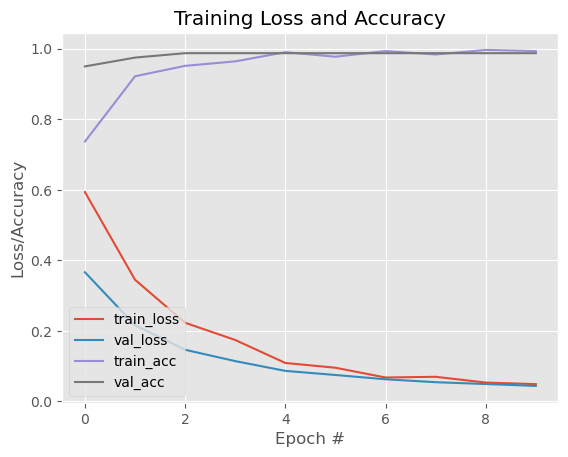

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("./plot.png")